# Investigation of Instability wrt Minor Parameter Tweaks
> __Purpose__: The goal of this notebook is to determine why minor variations in the parameters (i.e. the E and g values being changed by 1% either up or down) leads to unstable outcomes (i.e. no APs, but rather the y axis going to arbitrarily high and unrealistic values).

> Note that the issue with burn in has not yet been fixed

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import network_funcs

COLOR = 'grey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [2]:
def odes_progen(x,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations

    Params:: 
        x: all network parameters
        t: time vector, not called in func but regardless (but used in odeint)
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function

    Returns:: Differential equations of each variable as a vector
    '''
    
    ######### DEFINITIONS #########
    
    ### THIS IS MANUALLY SET AND MUST MATCH THE INPUT ###
    maxParams = 5 #Takes advantage of the fact that there will be a tau, v0, inf, etc. for each gating var
    #^ ie we can keep reusing this since there will be the same number of parameters necessary for each gating var
    #This is quasi-manual, based on the maxParams being 5... could probably make the equation itself automated?
    p = [1,20,-len(x)]
    roots = np.roots(p)
    numNodes = int(roots[1])

    numSC = numNodes-1 #calc_conx(numNodes)*2 <-- This is the total number of connections, but we only need to pass the max number of connections per node in for each node
    ES = [0] * numSC #ENa #mV #Excitatory Neuron (by this definition)
    
    #Convert list input into a matrix
    numParams = 1+4*maxParams+numSC #In this current form, there are 26 parameters per node.  I.e. 1 node is (1,26)
    x = np.reshape(x,(numNodes,numParams))
    
    if len(x.shape)==1:
        #Ie if it is 1D, expand the dim to be (1,X) so that we can index as if it were 2D
        x = np.expand_dims(x,0)
        
    firstSIndex = numParams-numSC
    
    infs = np.zeros((numNodes,maxParams))
    taus = np.zeros((numNodes,maxParams))
    dxdts = np.zeros((numNodes,numParams)) #ONE FOR EACH VAR PASSED IN THROUGH Y0

    ######### CONSTANTS #########
    CmBase = 0.01 #uF
    #Altering the current for the nodes, essentially weighting them
    #In the test trials in NB 10, we used 1x for node1, and 0x for node2
    node_current = [0]*numNodes
    node_current[0] = 1
    if numNodes>1:
        #Do something more advanced later
        node_current[1] = 0
    node_current = np.array(node_current)*(1/CmBase)
    
    #For the synaptic coupling: 
    #^20 was a "good value" (ie one for which it functioned) in the previous NB
    gbars = [20] * numSC
    
    ######### LOOPING #########
    
    for nodeTemp in range(numNodes):  
        #Weighting matrix
        WM = np.random.randint(low=998,high=1002,size=maxParams*4+1)/1000
        #WM = [0.998, 1.001, 1.001, 0.998, 0.999, 0.998, 1.001, 0.998, 0.998, 0.999, 0.999, 0.998,1,0.99,1,0.999, 0.999, 1, 0.999, 0.999, 0.998]
        #^Rand generated but this one hasn't failed yet...
        
        #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
        #reversal potentials
        ENa = 55.17*WM[0] #mV
        EK = -72.14*WM[1] #mV
        EL = -57.99*WM[2] #mV #-49.42
        #E4
        #E5
        #membrane capacitance
        Cm = CmBase*WM[5] #uF/cm^2
        
        #conductances (S is Siemens)
        gbarK = 0.36*WM[6] #mS/cm2
        gbarNa = 1.2*WM[7] #mS/cm2
        gbarL = 0.003*WM[8] #mS/cm2
        #So really there should be other values here for the 4th and 5th gating variables should those get used
        #gbar?(4) = ___
        #gbar?(5) = ___

        #For now, defining every neuron the same, but can change the "n,m,h" values...
        gK = (1/Cm)*gbarK*(x[nodeTemp,1]**4) #Why did I have a +maxParams after the 1?
        gNa = (1/Cm)*gbarNa*(x[nodeTemp,2]**3)*x[nodeTemp,3]
        gL = (1/Cm)*gbarL
        #Again, would need to add something for the 4th and 5th gating variables should they exist
        #...
        
        #Simplification: check connection in external function
        vnode_couplings = []
        svars = []   
        if numNodes==1:
            svars = [0]*numSC #1 neuron, so no connections.  Just return 0s
        else:
            SC_repo = network_funcs.check_SC(nodeTemp,numNodes) #RETURNS A DICTIONARY   

            if SC_repo is not None and len(SC_repo)>0:
                for idx in range(numNodes):
                    idx = str(idx + 1) #Adjust for offset, first node is 1 not 0
                    if SC_repo.get(idx) is not None:
                        adj_idx = int(idx)-1
                        vnode_couplings.append(adj_idx) #This is the node that it is coupled to
                        sval = float(SC_repo.get(idx))
                        svars.append(sval) #This is the s val, to be used in gs

                #Don't think this loop should actually ever run anymore
                while len(svars)<numSC:
                    vnode_couplings.append(0)
                    svars.append(0)

                my_zeros = [0]*(firstSIndex) #Ie a 1,21 vector of zeros, so once we add the 5 couplings to it, it meets 26
                svars_full = my_zeros+svars
                vnode_couplings_full = my_zeros+vnode_couplings
            else:
                print("Error: SC_repo returned None")
        gs = np.array(gbars) * np.array(svars) #* (1/Cm)

        #Define the steady state (inf) values, and the time constants (tau)
        #Note that this must be completed first, so that all the taus, infs are defined before we can make the ODEs
        for param in range(maxParams):
            #inf(V, v0, sigma)
            infs[nodeTemp,param] = network_funcs.inf_func(x[nodeTemp,0], x[nodeTemp,param+(1+maxParams)], x[nodeTemp,param+(1+2*maxParams)])
            #tau(V, mean)
            taus[nodeTemp,param] = network_funcs.tau_func(x[nodeTemp,0], x[nodeTemp,param+(1+3*maxParams)])

        #Define each ODE    
        for param in range(numParams): 
            if param==0:
                #dVdt = (gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + gs1*(ES1-Va) + ... + gsn*(ESn-Vz) + I(t,vI))
                
                #TERM 1
                ionChannels = gNa*(ENa-x[nodeTemp,0]) + gK*(EK-x[nodeTemp,0]) + gL*(EL-x[nodeTemp,0])
                #Would need to include the 4th and 5th gating variables somehow...
                #How to make this automatic instead of manual...
                
                #TERM 2
                synCoups = 0
                for idx in range(numSC):
                    #Replaced vnode_couplings[idx]-1 with idx
                    synCoups += gs[idx]*(ES[idx]-x[nodeTemp,0])
                    #^ Terms: (conducance gs_x) * (ES - V)

                #TERM 3
                appliedCurrent = network_funcs.I(t,vI)*node_current[nodeTemp]

                dxdts[nodeTemp,param] = ionChannels + synCoups + appliedCurrent
            elif param<(maxParams+1): #ie the gating variables
                #Note we use [nodeTemp,param-1] because there is no tau/inf for V so the matrix tau starts with n @ index 0
                dxdts[nodeTemp,param] = network_funcs.diffEQ_func(taus[nodeTemp,param-1], infs[nodeTemp,param-1], x[nodeTemp,param]) 
            elif param>=firstSIndex and sum(svars_full)==0: #ie if all the s vars are equal to zero
                break #ie just leave them as zero, and we are done with the loop so we can just break
            elif param>=firstSIndex:
                #STILL MANUAL
                tau_s = 30 #ms
                s_inf = 10.0/11.0 
                beta_s = 1/tau_s
                
                if numNodes==1:
                    pass #ie dsdts remain zeros
                else:
                    s = svars_full[param]
                    if s==0:
                        #Not sure if this will ever happen
                        #Goal is to get around cases where no s is passed in so s is 0
                        #^Maybe initilize that array to something biophysically impossible (e.g. can s be neagtive?)
                        dxdts[nodeTemp,param] = 0 
                    else:
                        coupled_neuron = vnode_couplings_full[param]
                        #coupled_neuron-1 because Neuron 1 corresponds to row 0
                        alpha_s = (x[coupled_neuron-1,0]>0)*(1/tau_s)

                        dxdts[nodeTemp,param] = alpha_s*(1-s)-beta_s*s 
                
                #This should be the last case, it will run once the way it currently configured
                #break
            else:
                pass
                #Should just be equal to zero, so leave as is (matrix is initialized as zeros)
    
    #Rearrange dxdts into a list so that we can unpack it
    flat_array = dxdts.flatten()
    ODE_list = flat_array.tolist()
    
    return ODE_list

In [3]:
#Things that don't need to be assigned every time
t = np.linspace(0,50,2000) #time vector
vI = [0,0,0] #vector needed to control the current
V1 = -58; n1 = 0.05; m1 = 0.33; h1 = 0.6 #Voltage and gating var ICs
#V0: Manipulates the x location placement
V0n1 = -49; V0m1 = -36; V0h1 = -55
#Sigma: Manipulates the steepness, bigger sigma means less steep step
sigman1 = 18; sigmam1 = 10; sigmah1 = -8
#Tau's
tau_n_mean1 = 2.785; tau_m_mean1 = 0.258; tau_h_mean1 = 2.810
node1Base = [V1, n1, m1, h1, 0, 0, 
         V0n1, V0m1, V0h1, 0, 0, 
         sigman1, sigmam1, sigmah1, 0, 0, 
         tau_n_mean1, tau_m_mean1, tau_h_mean1, 0, 0]

In [14]:
def runSim(vI,numNodes=1,plot_BI=True,plot_final=True,useCurrent=True,isVerbose=0,my_tol=1.49012e-8):
    print("Burn in run, looking for NO oscillations")
    node1 = node1Base + ([0]*(numNodes-1))
    network_params = node1*numNodes #Letting all nodes be the same
    if isVerbose:
        x, my_verbosity = odeint(odes_progen,network_params,t,full_output=isVerbose,rtol=my_tol,args=(network_funcs.I,vI))
        print(my_verbosity)
    else:
        x = odeint(odes_progen,network_params,t,full_output=isVerbose,rtol=my_tol,args=(network_funcs.I,vI))
    x = np.transpose(x)
    if plot_BI:
        network_funcs.plot_vnmh(x,t,numNodes)
    #Now grab the burned in values from the previous run
    network_params_BI = x[:,-1]
    print("Burn in complete")
    print("Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected")
    #BURNED IN initial condition
    if useCurrent:
        vI = [5,7,0.1]
    if isVerbose:
        x, my_verbosity = odeint(odes_progen,network_params,t,rtol=my_tol,full_output=isVerbose,args=(network_funcs.I,vI))
        print(my_verbosity)
    else:
        x = odeint(odes_progen,network_params,t,full_output=isVerbose,rtol=my_tol,args=(network_funcs.I,vI))
    x = np.transpose(x)
    if plot_final:
        network_funcs.plot_vnmh(x,t,numNodes)

## Phase 1: Test with 1 Neuron Case

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


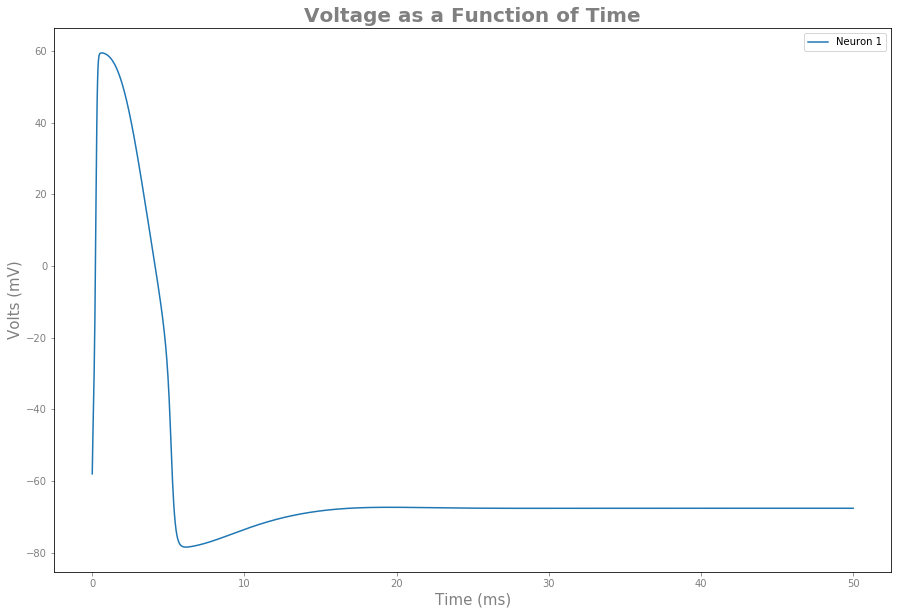

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


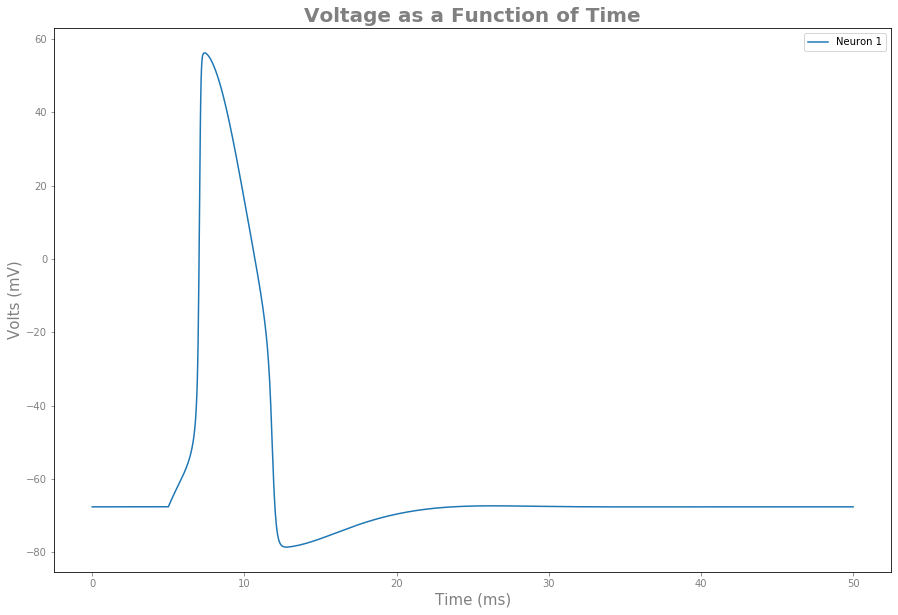

In [32]:
#WM = 1.1 #i.e. the entire weighting matrix, all 21 terms, are equal to 1.1, i.e. applying a 10% increase
runSim(vI)

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


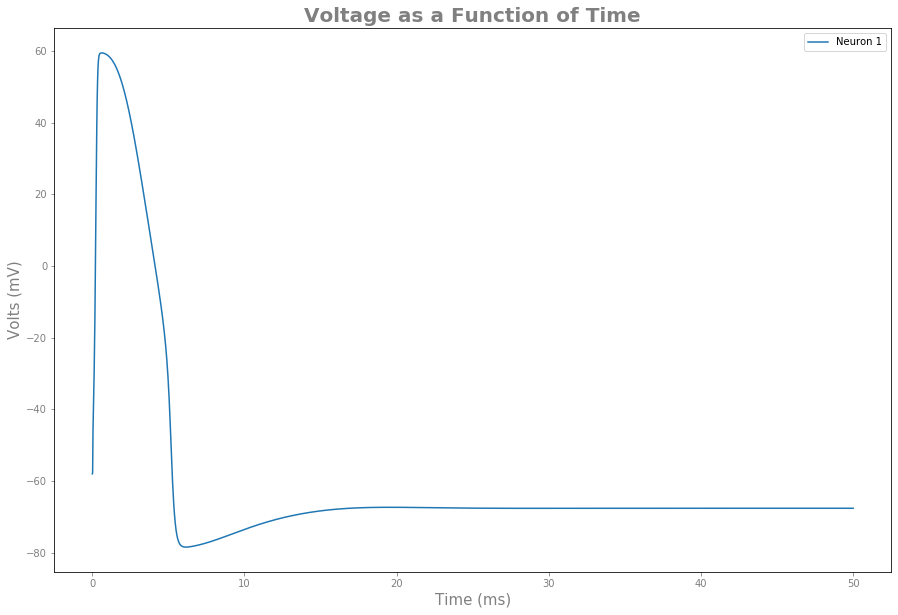

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


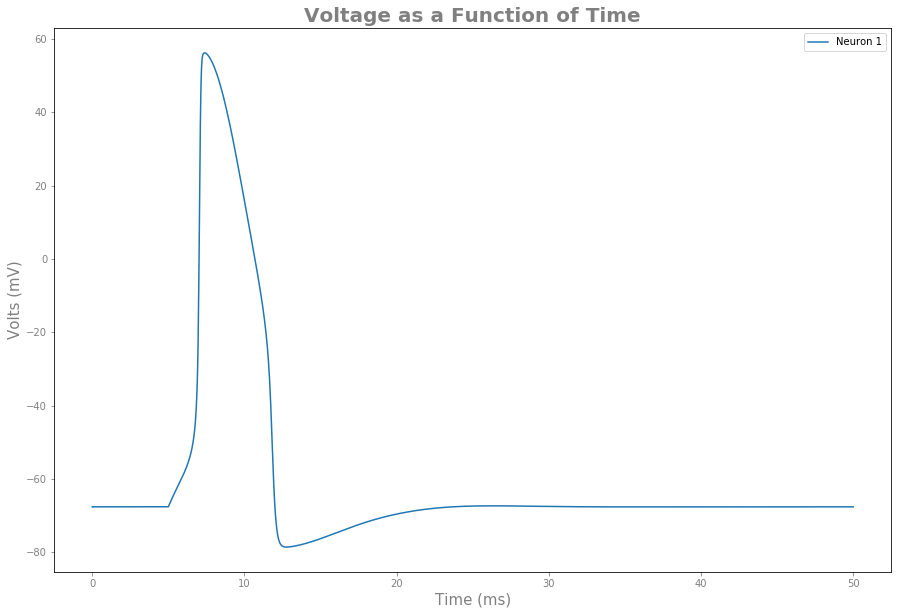

In [37]:
#WM = rand vals
runSim(vI)

## Phase 2: Repeating Phase 1 But With a 2 Neuron Network
> From the results below it is clear that random weightings (between 0.99 and 1.01) break the model, but when all the weightings are the same (i.e. WM is equal to 1.05 or 0.9 or etc) the model appears to be fine.

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


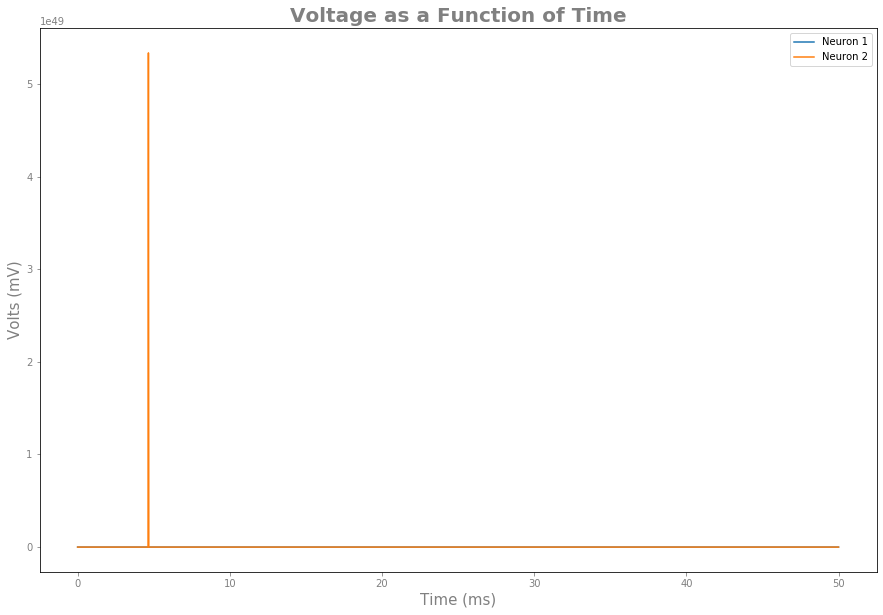

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


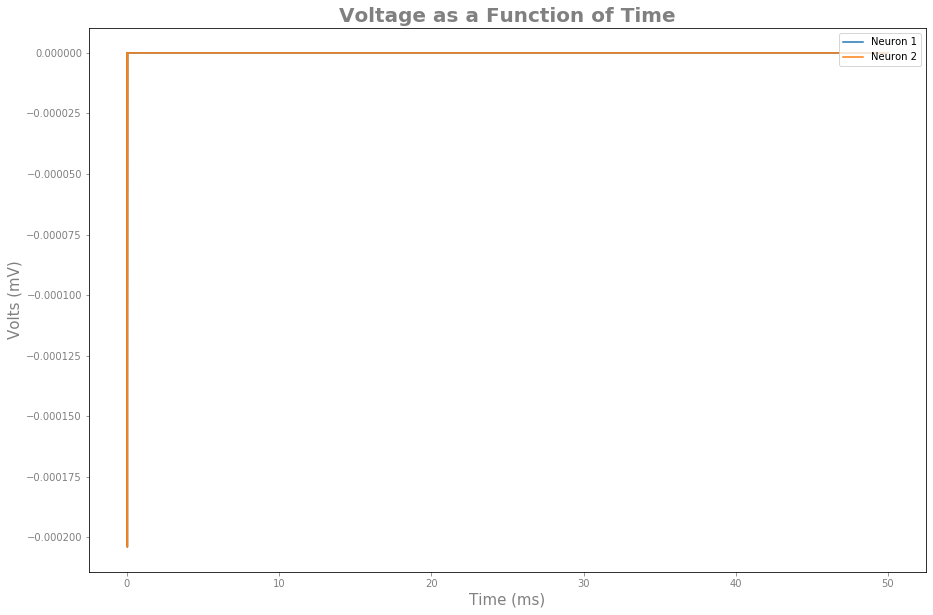

In [38]:
#WM = rand vals
runSim(vI,numNodes=2)

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


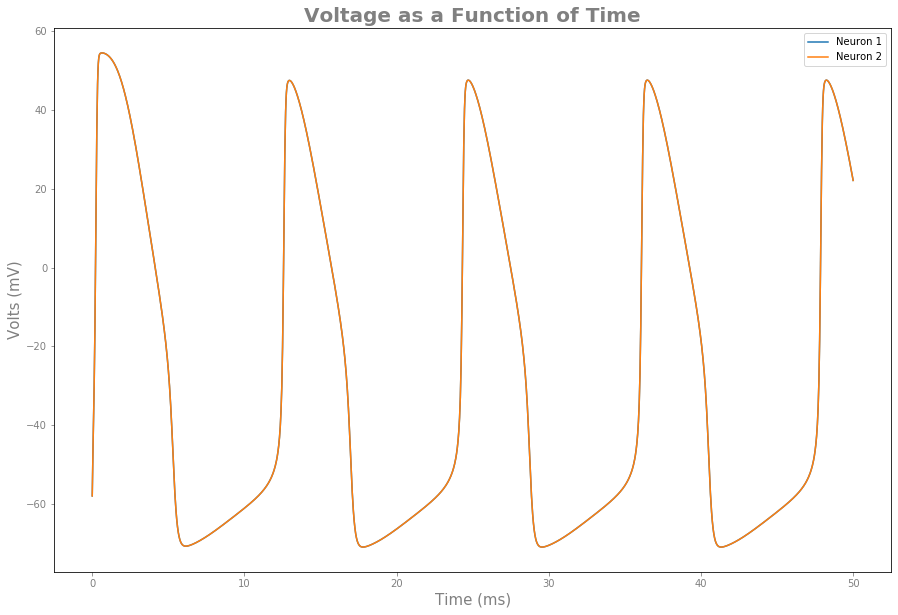

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


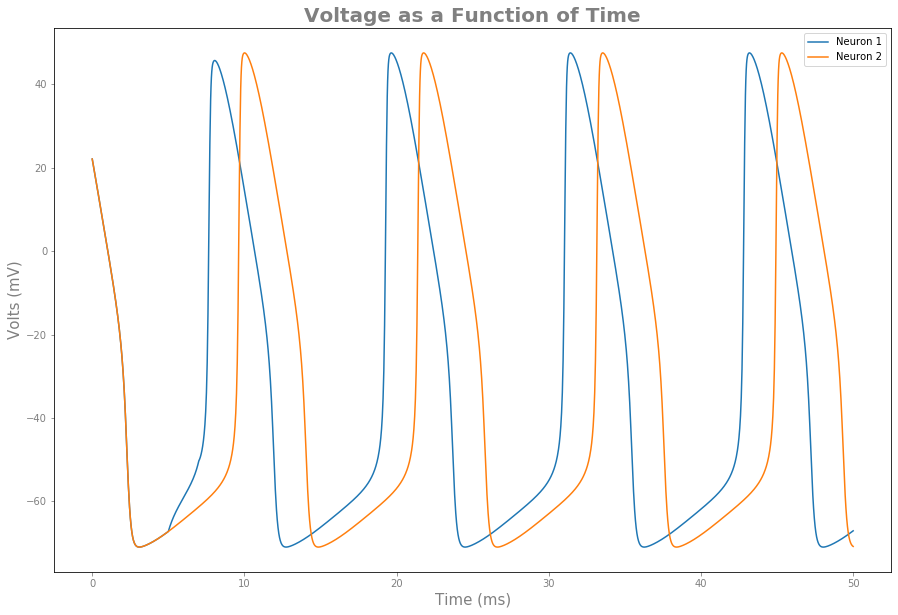

In [41]:
#WM = 1.01
runSim(vI,numNodes=2)

Burn in run, looking for NO oscillations


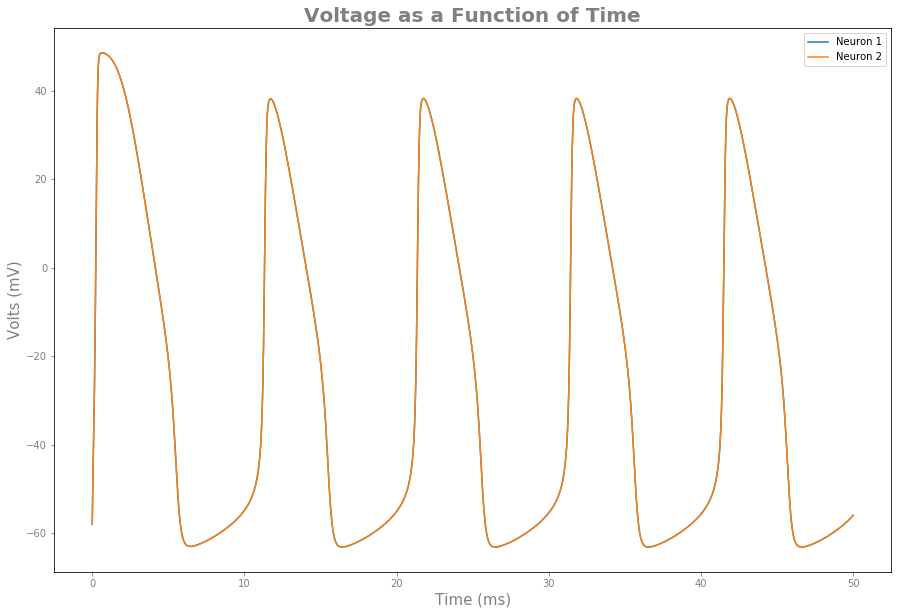

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


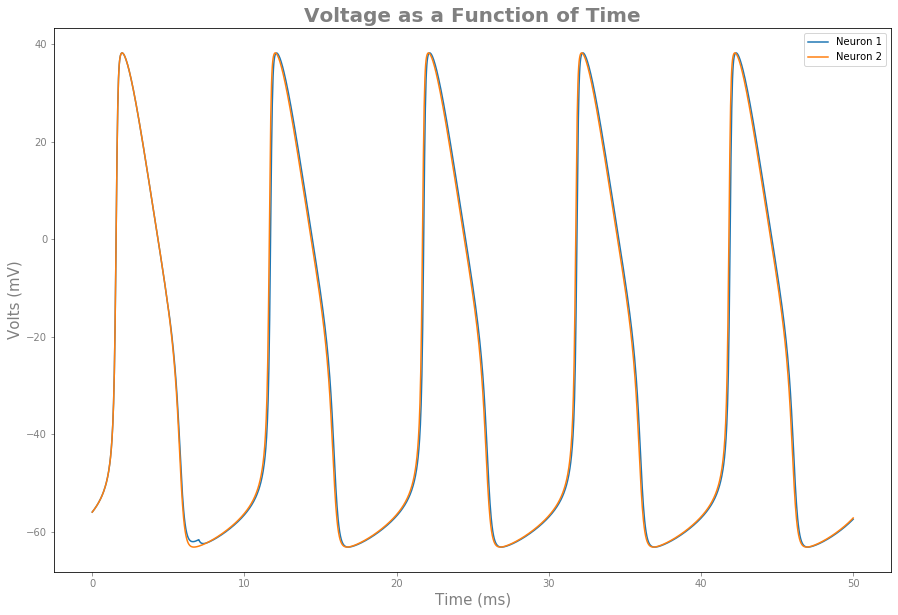

In [49]:
#WM = 0.9
runSim(vI,numNodes=2)

## Phase 3: Isolation: Weighting One Var In Each Run
> Above, the 2 neuron case breaks whenever the weight matrix applied to all values is not the same (i.e. muliplying everything by 1.1 works fine, but multiplying each number with a random value between 1.01 and 0.99 breaks it).  The goal of
> Conclusion: By themselves (i.e. having all values being weighted the same, EXCEPT for one value), individual weighting of up to 5% does not break the model... Thus, what is the case that breaks the model?
1. Multiple (2+) values being weighted randomly/independently?
    - If so, how many values can be weighted indepedently before the model breaks?
          - Investigate this is the section below this one

Burn in run, looking for NO oscillations


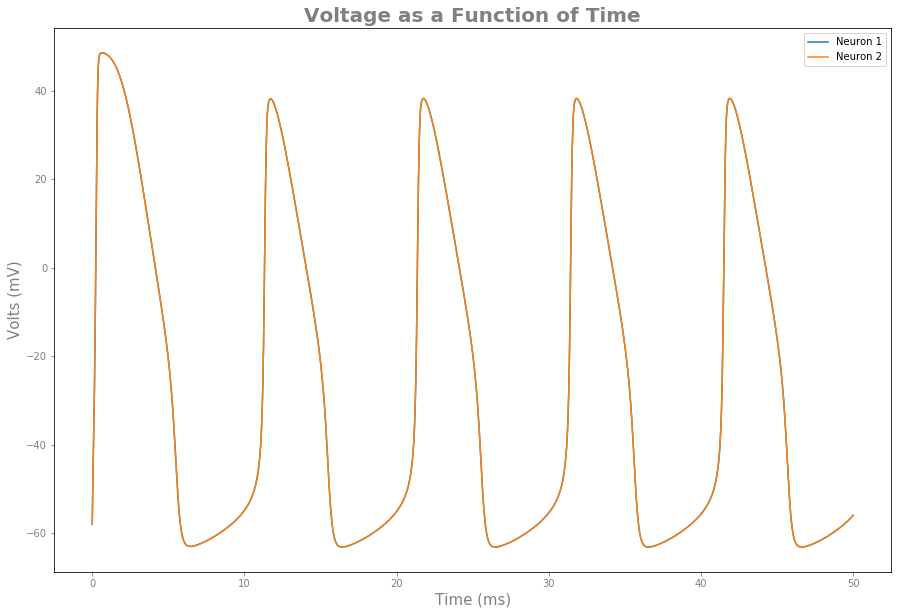

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


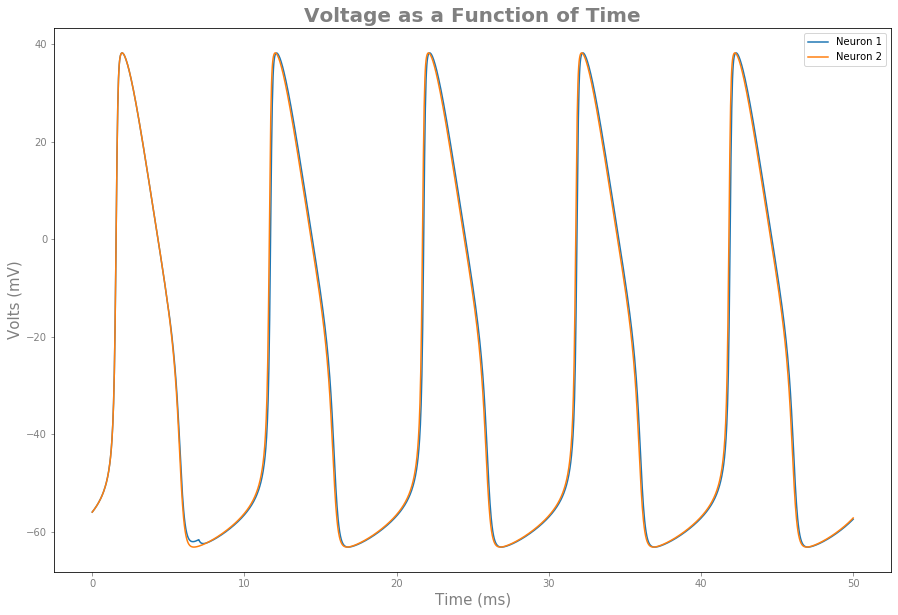

In [51]:
#WM[0] = 1.05
runSim(vI,numNodes=2)

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


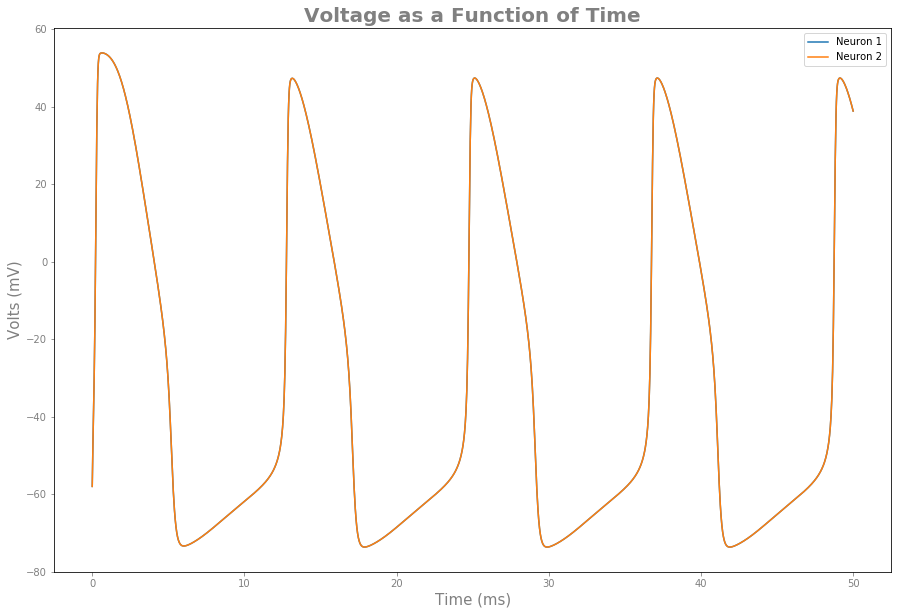

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


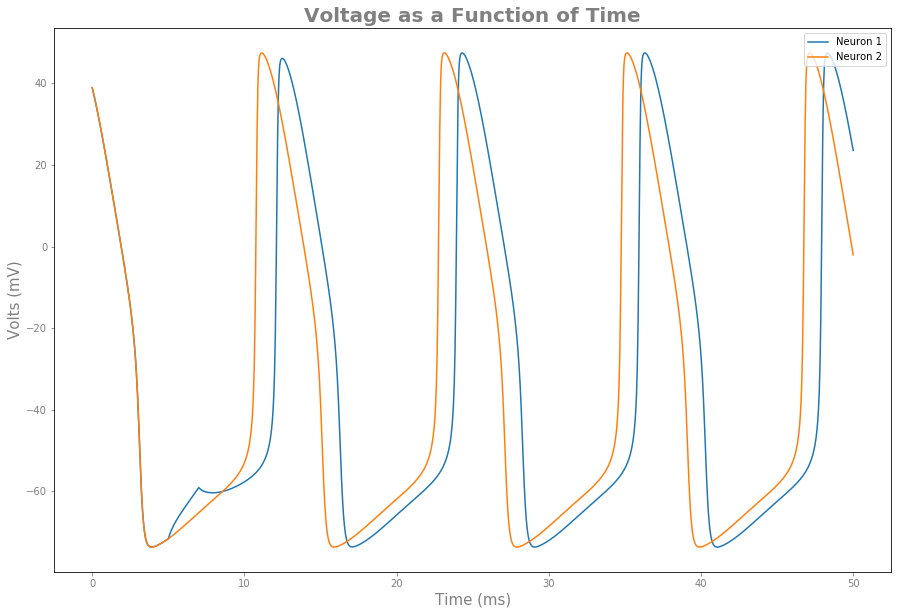

In [54]:
#WM[1] = 1.05
runSim(vI,numNodes=2)

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


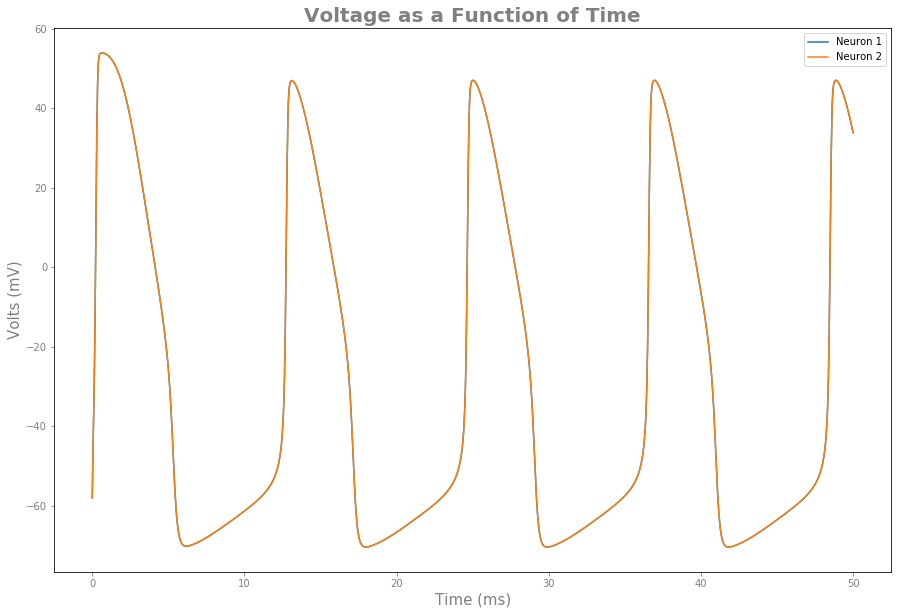

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


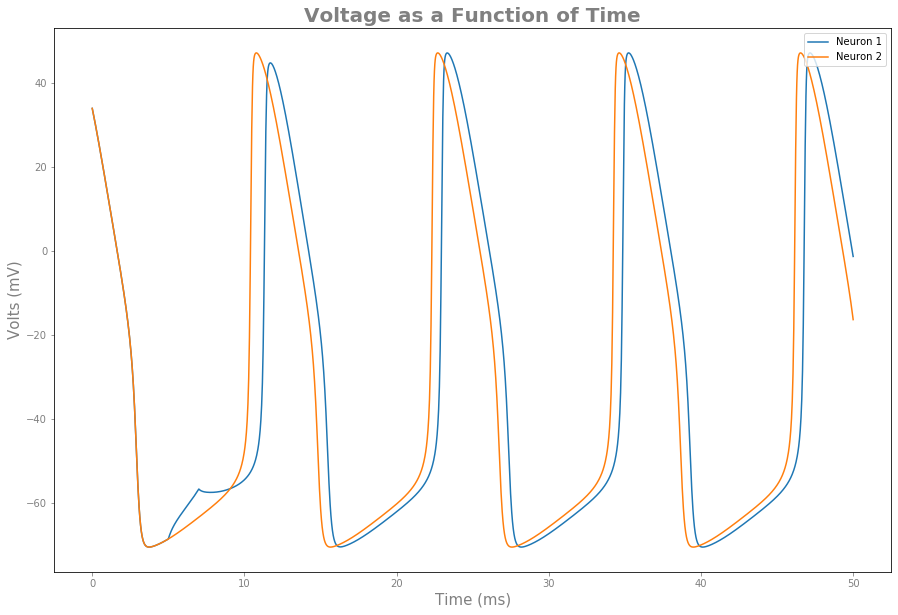

In [56]:
#WM[2] = 1.05
runSim(vI,numNodes=2)

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


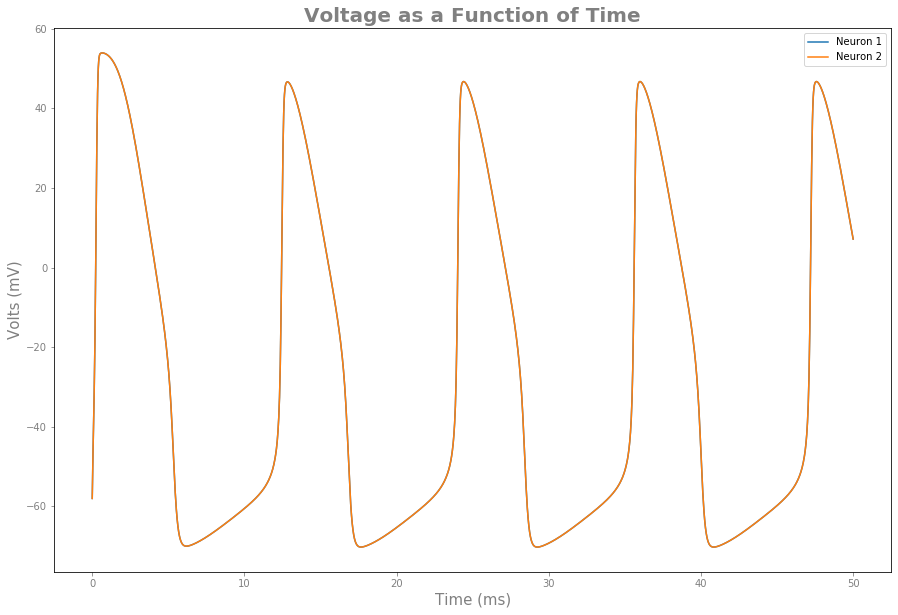

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


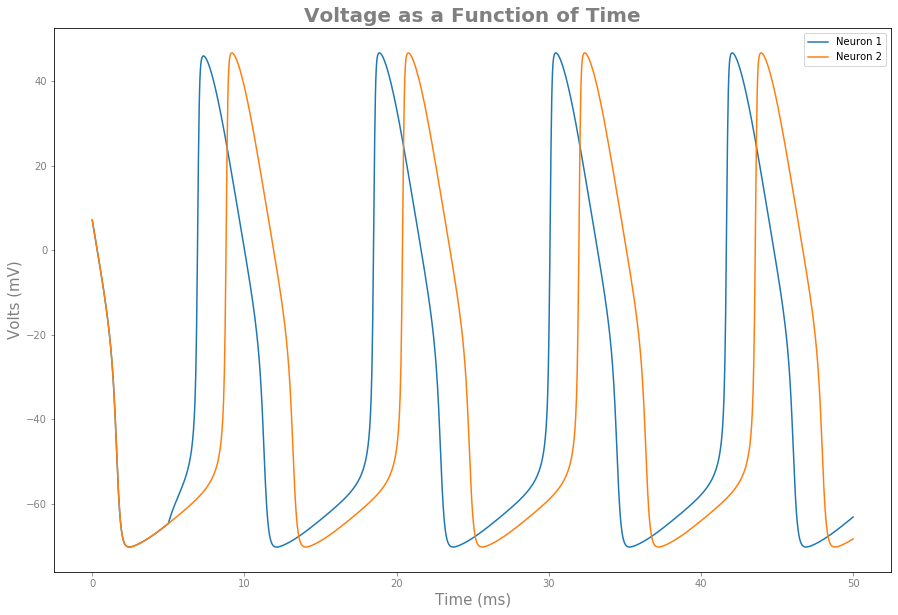

In [59]:
#WM[5] = 1.05 (Cm)
runSim(vI,numNodes=2)

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


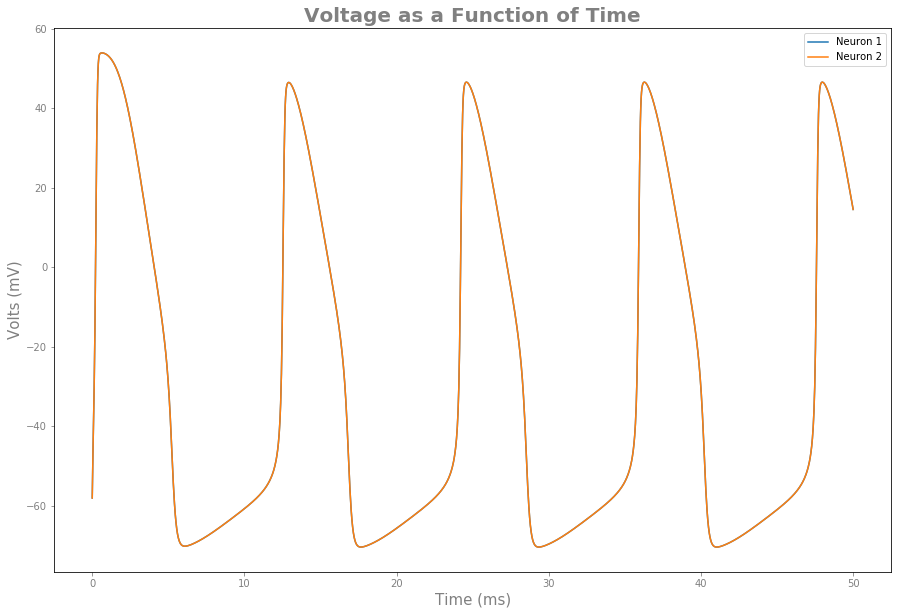

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


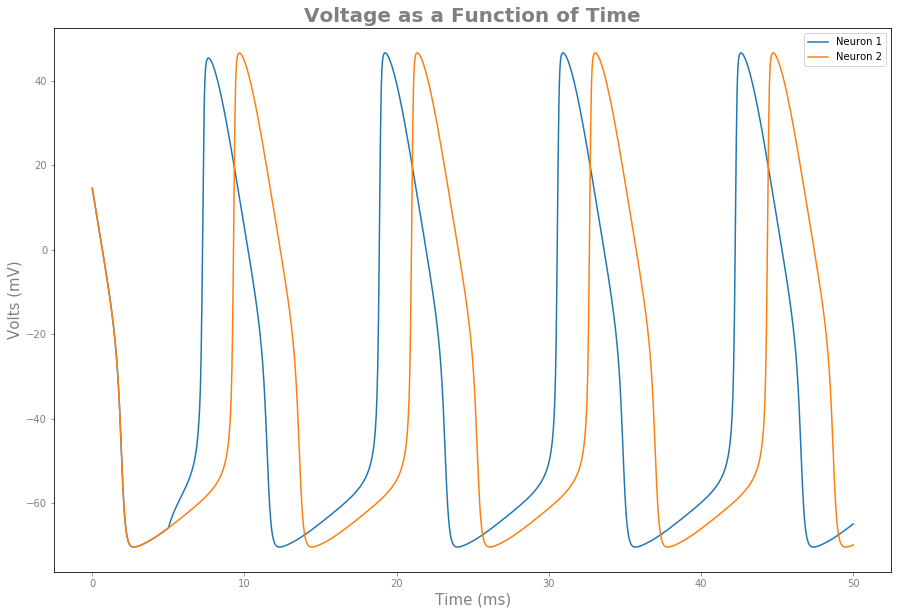

In [63]:
#WM[6] = 1.05
runSim(vI,numNodes=2)

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


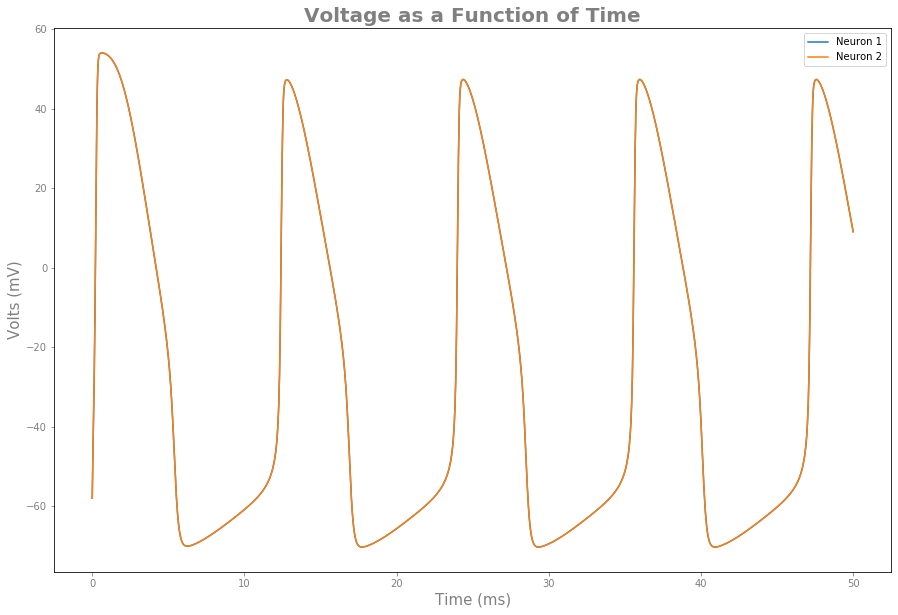

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


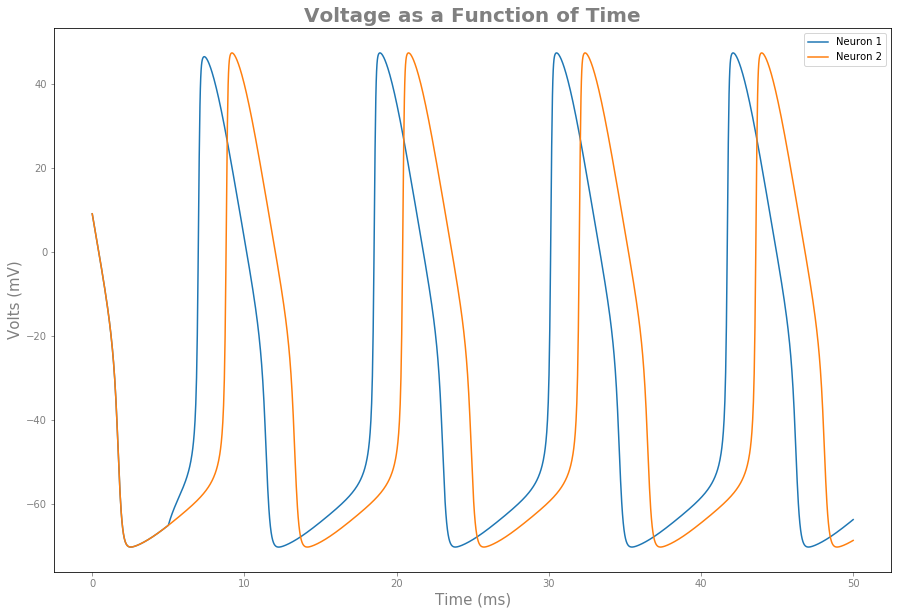

In [66]:
#WM[7] = 1.05
runSim(vI,numNodes=2)

In [ ]:
#WM[8] = 1.05
runSim(vI,numNodes=2)

## Phase 4: Repeating Phase 3 Weighting an Additional Var Each Run

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


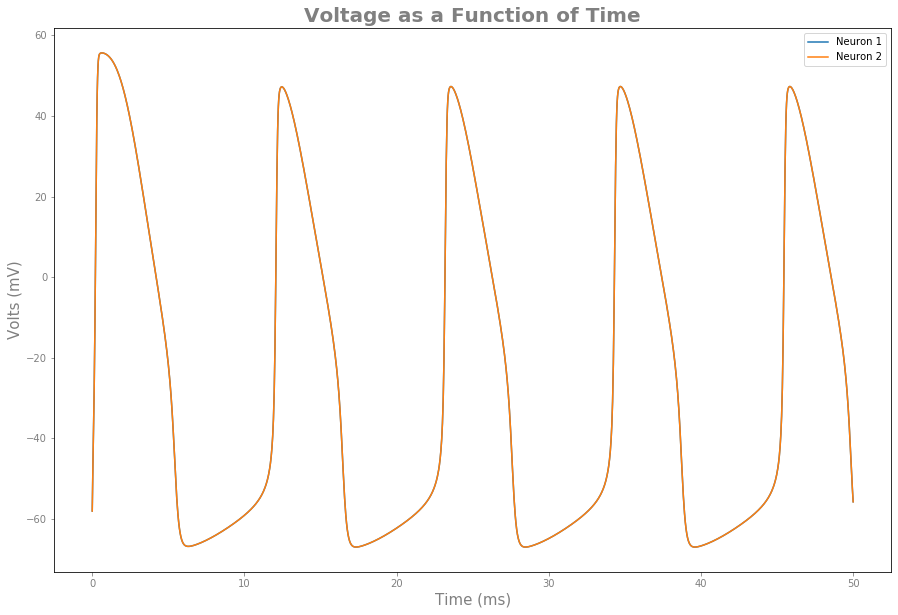

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


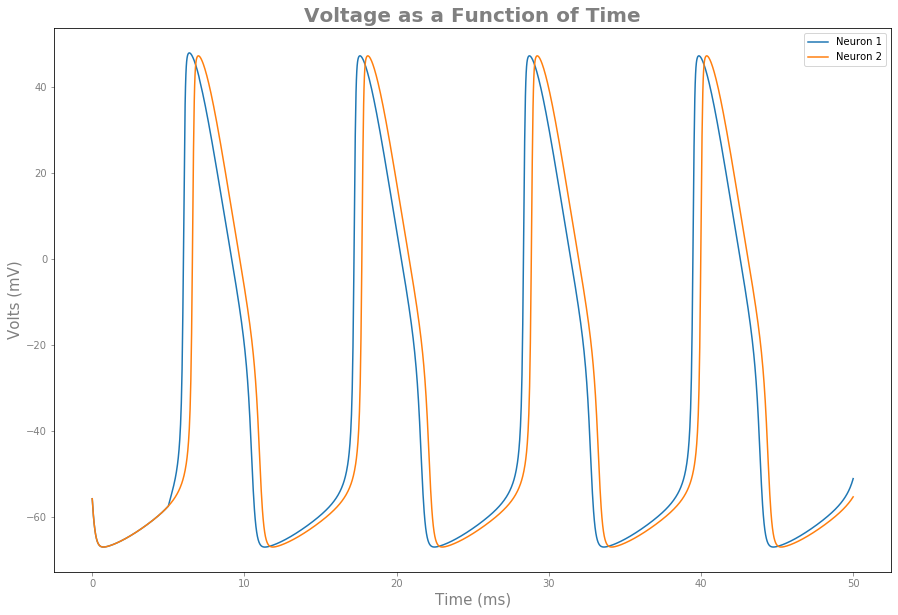

In [74]:
#WM[0] = 1.03
#WM[1] = 0.95
#WM[2] = 0.99
#WM[5] = 0.98
#WM[6] = 1.05
#WM[7] = 1.02
runSim(vI,numNodes=2)

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


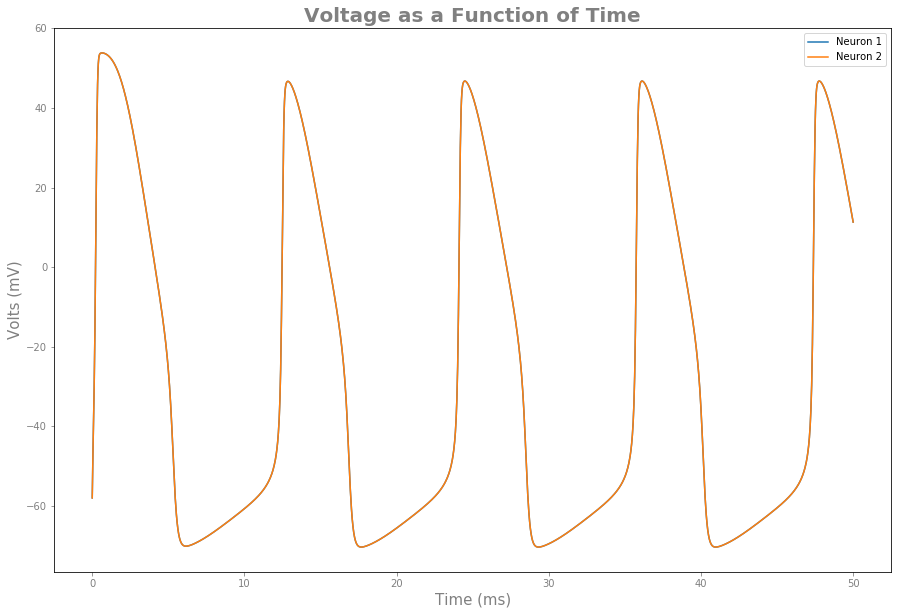

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


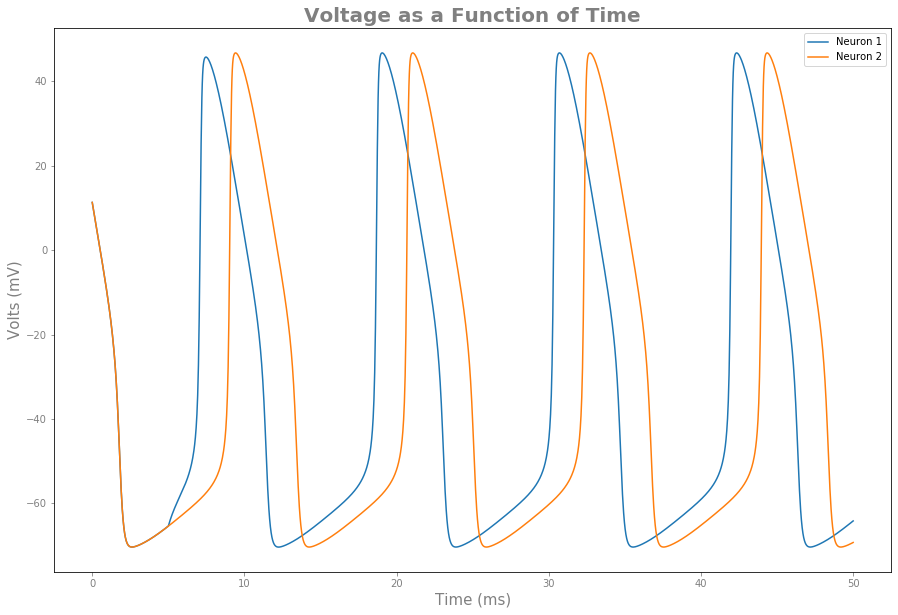

In [79]:
#Running with completely random weightings between 0.998 and 1.002
runSim(vI,numNodes=2)

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


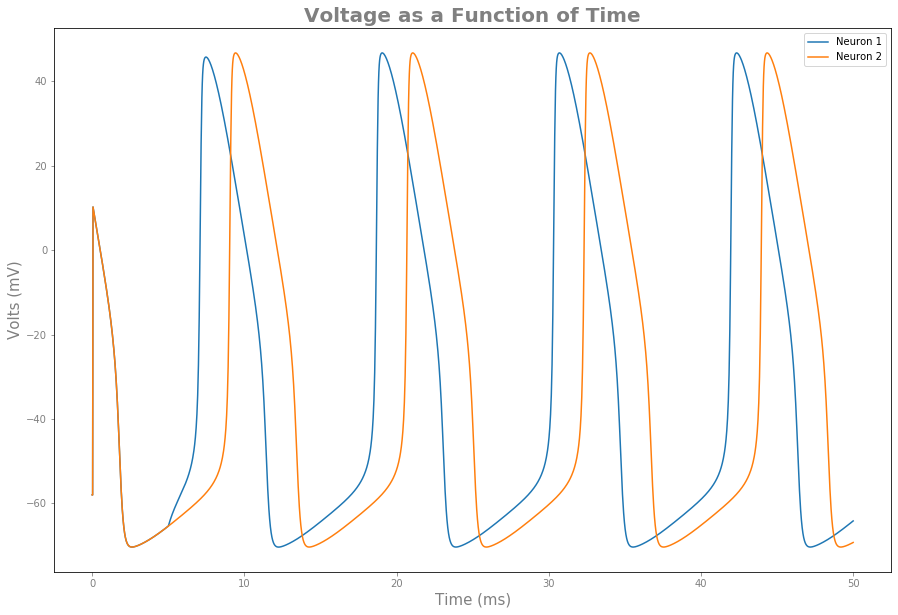

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


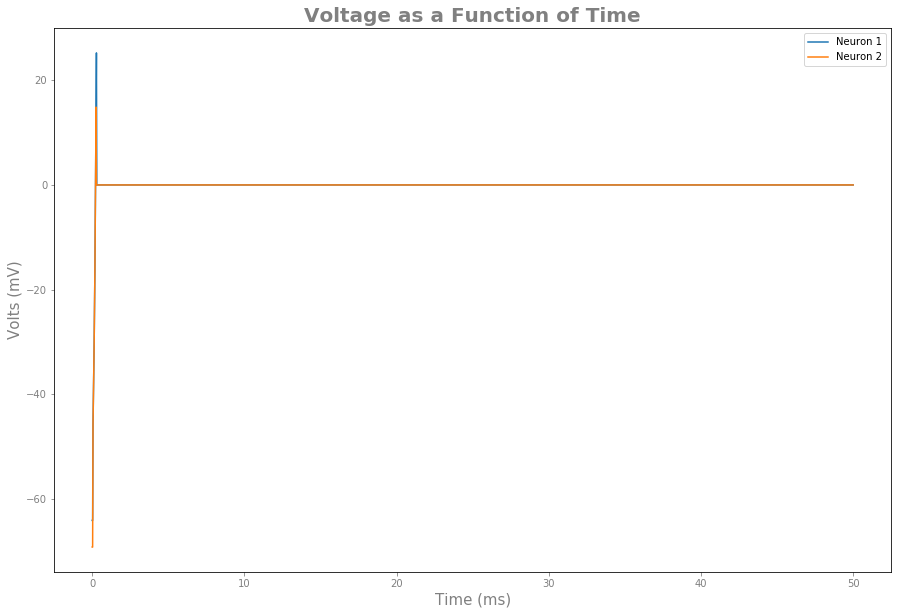

In [84]:
#Running with completely random weightings between 0.998 and 1.002
runSim(vI,numNodes=2)

Burn in run, looking for NO oscillations


C:\Users\14193\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


{'hu': array([2.72810904e-07, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'tcur': array([8.54236234e-06, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'tolsf': array([1.84347044e+228, 0.00000000e+000, 0.00000000e+000, ...,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000]), 'tsw': array([3.97520108e-06, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'nst': array([36,  0,  0, ...,  0,  0,  0], dtype=int32), 'nfe': array([1204,    0,    0, ...,    0,    0,    0], dtype=int32), 'nje': array([25,  0,  0, ...,  0,  0,  0], dtype=int32), 'nqu': array([1, 0, 0, ..., 0, 0, 0], dtype=int32), 'imxer': 23, 'lenrw': 2354, 'leniw': 64, 'mused': array([2, 0, 0, ..., 0, 0, 0], dtype=int32), 'message': 'Repeated convergence failures (perhaps bad Jacobian or tolerances).'}


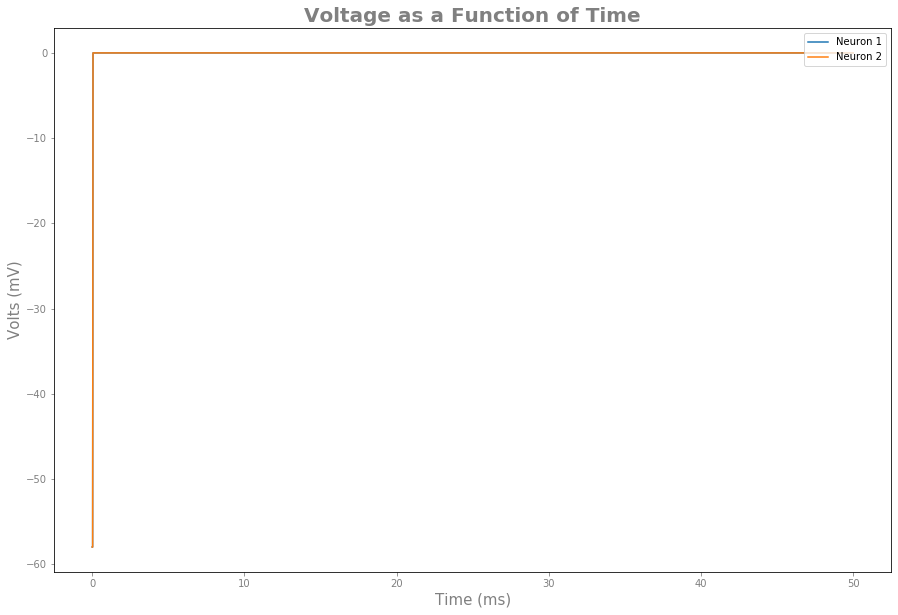

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


{'hu': array([3.54720439e-07, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'tcur': array([5.65504581e-06, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'tolsf': array([0., 0., 0., ..., 0., 0., 0.]), 'tsw': array([4.54313603e-06, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), 'nst': array([24,  0,  0, ...,  0,  0,  0], dtype=int32), 'nfe': array([653,   0,   0, ...,   0,   0,   0], dtype=int32), 'nje': array([13,  0,  0, ...,  0,  0,  0], dtype=int32), 'nqu': array([         1,          0, -625240923, ...,  649947995,  776585673,
          9007385], dtype=int32), 'imxer': 1, 'lenrw': 2354, 'leniw': 64, 'mused': array([2, 0, 0, ..., 0, 0, 0], dtype=int32), 'message': 'Repeated convergence failures (perhaps bad Jacobian or tolerances).'}


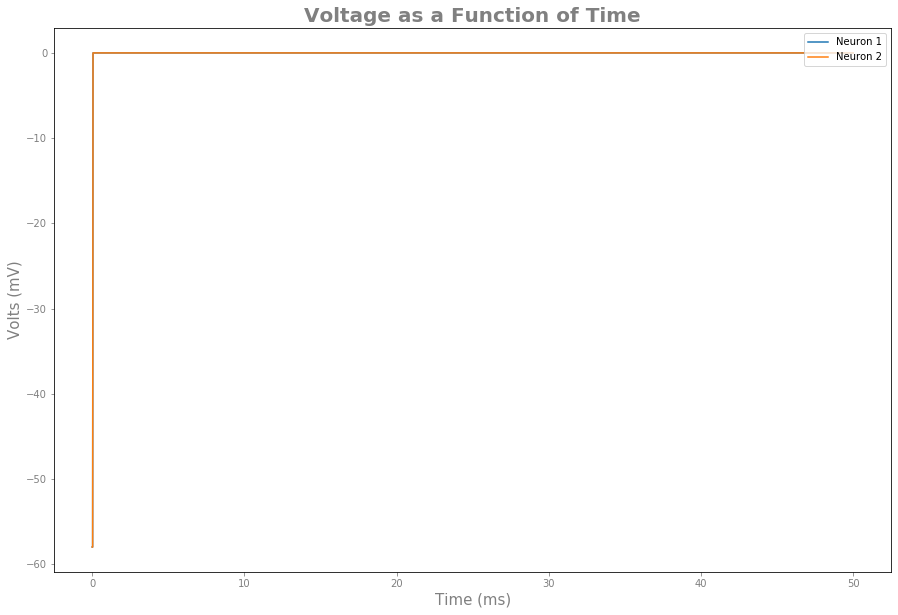

In [13]:
#Running with completely random weightings between 0.998 and 1.002
#runSim(vI,numNodes=2,my_tol=1e-4)
numNodes=2
plot_BI=True
plot_final=True
useCurrent=True
isVerbose=1
my_tol=1.49012e-8

print("Burn in run, looking for NO oscillations")
node1 = node1Base + ([0]*(numNodes-1))
network_params = node1*numNodes #Letting all nodes be the same
if isVerbose:
    x, my_verbosity = odeint(odes_progen,network_params,t,full_output=isVerbose,rtol=my_tol,args=(network_funcs.I,vI))
    print(my_verbosity)
else:
    x = odeint(odes_progen,network_params,t,full_output=isVerbose,rtol=my_tol,args=(network_funcs.I,vI))
x = np.transpose(x)
if plot_BI:
    network_funcs.plot_vnmh(x,t,numNodes)
#Now grab the burned in values from the previous run
network_params_BI = x[:,-1]
print("Burn in complete")
print("Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected")
#BURNED IN initial condition
if useCurrent:
    vI = [5,7,0.1]
if isVerbose:
    x, my_verbosity = odeint(odes_progen,network_params,t,rtol=my_tol,full_output=isVerbose,args=(network_funcs.I,vI))
    print(my_verbosity)
else:
    x = odeint(odes_progen,network_params,t,full_output=isVerbose,rtol=my_tol,args=(network_funcs.I,vI))
x = np.transpose(x)
if plot_final:
    network_funcs.plot_vnmh(x,t,numNodes)

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


{'hu': array([0.0003616, 0.       , 0.       , ..., 0.       , 0.       ,
       0.       ]), 'tcur': array([0.00125789, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]), 'tolsf': array([0., 0., 0., ..., 0., 0., 0.]), 'tsw': array([0.00013642, 0.02501251, 0.02501251, ..., 0.02501251, 0.02501251,
       0.02501251]), 'nst': array([        30, 1801677140, 1668246560, ...,  538970658,  538976288,
       1702043680], dtype=int32), 'nfe': array([       698,  540697972,  543516756, ..., 1646290280, 1701536609,
       1713398894], dtype=int32), 'nje': array([14,  0,  0, ...,  0,  0,  0], dtype=int32), 'nqu': array([         3, 1935764547,  544433523, ..., 1701344288, 1970236704,
       1914725747], dtype=int32), 'imxer': 23, 'lenrw': 2354, 'leniw': 64, 'mused': array([2, 0, 0, ..., 0, 0, 0], dtype=int32), 'message': 'Repeated convergence failures (perhaps bad Jacobian or tolerances).'}


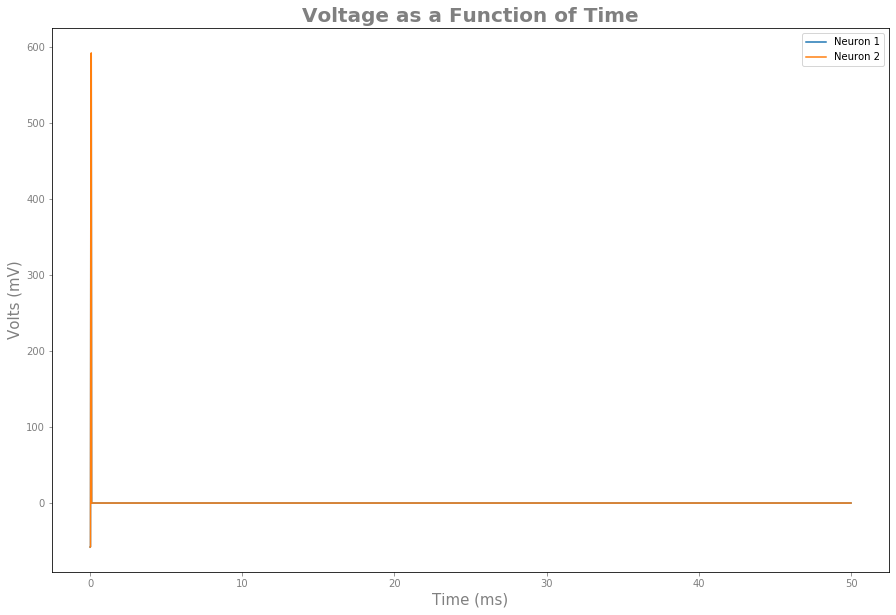

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


{'hu': array([0.00027157, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]), 'tcur': array([0.00057584, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]), 'tolsf': array([0.00000000e+000, 4.96042068e+180, 1.42717962e+248, ...,
       1.81450402e-152, 5.94839080e+228, 2.46276934e+198]), 'tsw': array([ 1.30223562e-004,  5.04533119e+223,  1.20479907e+132, ...,
        4.75602066e-312, -1.12832705e+247, -1.64271829e-052]), 'nst': array([26,  0,  0, ...,  0,  0,  0], dtype=int32), 'nfe': array([644,   0,   0, ...,   0,   0,   0], dtype=int32), 'nje': array([13,  0,  0, ...,  0,  0,  0], dtype=int32), 'nqu': array([2, 0, 0, ..., 0, 0, 0], dtype=int32), 'imxer': 1, 'lenrw': 2354, 'leniw': 64, 'mused': array([2, 0, 0, ..., 0, 0, 0], dtype=int32), 'message': 'Repeated convergence failures (perhaps bad Jacobian or tolerances).'}


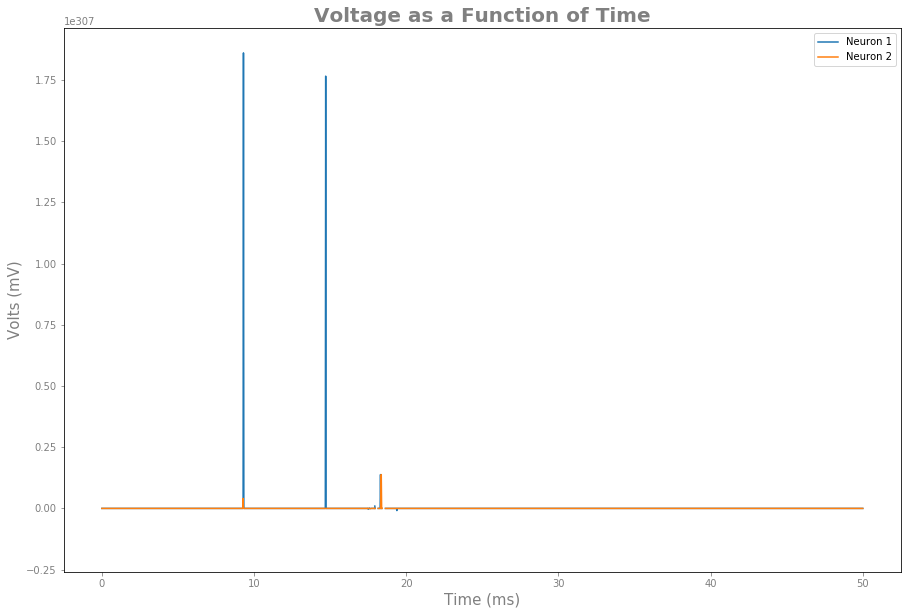

In [17]:
#full_output
#Running with completely random weightings between 0.998 and 1.002
runSim(vI,numNodes=2,isVerbose=1,my_tol=1e-6)